# First: I need to prepare my data

In [1]:
import os
import numpy as np # type: ignore
import pandas as pd

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from pmdarima.arima import ARIMA

from pmdarima.arima.stationarity import ADFTest, KPSSTest
from pmdarima.arima.utils import ndiffs, nsdiffs
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.metrics import smape 

In [3]:
time_series = pd.read_csv("datasets/top_5_countries.csv", index_col=0, parse_dates=True)

In [4]:
time_series.head()

,DE_load_actual_entsoe_transparency,DE_solar_generation_actual,DE_wind_generation_actual,DE_wind_offshore_generation_actual,DE_wind_onshore_generation_actual,ES_load_actual_entsoe_transparency,ES_solar_generation_actual,ES_wind_onshore_generation_actual,FR_load_actual_entsoe_transparency,FR_solar_generation_actual,...,GB_UKM_wind_onshore_generation_actual,IT_load_actual_entsoe_transparency,IT_solar_generation_actual,IT_wind_onshore_generation_actual,DayOfWeek,DayOfMonth,Year,Month,HourOfDay,WeekOfYear
date,,,,,,,,,,,,,,,,,,,,,
2015-10-26 00:00:00,40494.0,0.0,2222.0,162.0,2060.0,20785.0,38.0,4826.0,46985.0,0.0,...,3463.0,20305.0,0.0,225.971411,0,26,2015,10,0,44
2015-10-26 01:00:00,40221.0,0.0,2471.0,166.0,2305.0,20275.0,38.0,4750.0,45507.0,0.0,...,3383.0,19902.0,0.0,225.957116,0,26,2015,10,1,44
2015-10-26 02:00:00,36221.0,0.0,2875.0,186.0,2689.0,20111.0,38.0,4537.0,43304.0,0.0,...,2633.0,19819.0,0.0,225.942822,0,26,2015,10,2,44
2015-10-26 03:00:00,43194.0,0.0,3458.0,238.0,3220.0,20328.0,38.0,4254.0,43159.0,0.0,...,3417.0,20425.0,0.0,225.928527,0,26,2015,10,3,44
2015-10-26 04:00:00,47788.0,0.0,4156.0,315.0,3841.0,20953.0,38.0,4392.0,46148.0,0.0,...,3456.0,22511.0,0.0,225.914232,0,26,2015,10,4,44


# 1. Split and scale data

In [5]:
# days in the dataset
days_in_data = int(len(time_series)/24)
print(f'{days_in_data} days in the dataset.')

1801 days in the dataset.


In [6]:
# To ensure we have full days in train, test, validation and also full dataset.

train_size = int(int(len(time_series)/24)*0.7)
test_size = int(int(len(time_series)/24)*0.2)
val_size = int(len(time_series)/24) - train_size - test_size
print(f'{train_size} days in the train dataset.\n {test_size} days in the test dataset.\n {val_size} days in the validation dataset.')

assert(days_in_data == train_size + test_size + val_size)

1260 days in the train dataset.
 360 days in the test dataset.
 181 days in the validation dataset.


In [7]:
num_train = train_size*24
num_test = test_size*24
num_vali = val_size*24
print(f'{num_train} observations in the train dataset.\n {num_test} observations in the test dataset.\n {num_vali} observations in the validation dataset.')

assert(len(time_series) == num_train + num_test + num_vali)

30240 observations in the train dataset.
 8640 observations in the test dataset.
 4344 observations in the validation dataset.


In [8]:
def split_scale_dataset(data, train_size, val_size, test_size=None):

    """
    data (pd.DataFrame): Dataframe with time series data.
    train_size, test_size, val_size (int): number of days in train, 
                                            test and validation datasets.

    return: Scaled datasets
    """

    num_train = train_size*24
    if test_size is not None:
        num_test = test_size*24
    num_vali = val_size*24

    train_data = data.iloc[:num_train] # 0, a-1
    vali_data = data.iloc[num_train: num_train + num_vali] # a, a+b-1
    test_data = data.iloc[num_train + num_vali:] # a+b

    assert(len(data) == len(train_data) + len(test_data) + len(vali_data))

    print(f'{len(train_data)} observations in the train dataset.\n {len(test_data)} observations in the test dataset.\n {len(vali_data)} observations in the validation dataset.')

    # initialize scaler object
    scaler = StandardScaler()

    # scale data
    train_data_sc = scaler.fit_transform(train_data)
    vali_data_sc = scaler.transform(vali_data)
    test_data_sc = scaler.transform(test_data)

    train_data_sc = pd.DataFrame(train_data_sc, columns=train_data.columns, index=train_data.index)
    vali_data_sc = pd.DataFrame(vali_data_sc, columns=vali_data.columns, index=vali_data.index)
    test_data_sc = pd.DataFrame(test_data_sc, columns=test_data.columns, index=test_data.index)

    return train_data_sc, vali_data_sc, test_data_sc


train, vali, test = split_scale_dataset(time_series.iloc[:, :-6], train_size, val_size)

30240 observations in the train dataset.
 8640 observations in the test dataset.
 4344 observations in the validation dataset.


In [9]:
def exog_variables(data, train_size, val_size, test_size=None):
    """
    data (pd.DataFrame): Dataframe with time series data.
    train_size, test_size, val_size (int): number of days in train, 
                                            test and validation datasets.

    return: Datasets with exogenous variables
    """
    num_train = train_size*24
    if test_size is not None:
        num_test = test_size*24
    num_vali = val_size*24

    train_data = data.iloc[:num_train][['HourOfDay', 'DayOfWeek']] # 0, a-1
    vali_data = data.iloc[num_train: num_train + num_vali][['HourOfDay', 'DayOfWeek']] # a, a+b-1
    test_data = data.iloc[num_train + num_vali:][['HourOfDay', 'DayOfWeek']] # a+b

    return train_data, vali_data, test_data

train_exog, vali_exog, test_exog = exog_variables(time_series.iloc[:, -6:], train_size, val_size)


# 1. Stationarity test

Perform stationarity test on train data.

In [9]:
# https://alkaline-ml.com/pmdarima/1.3.0/tips_and_tricks.html?highlight=kpss

def stationary_seasonal(data, column_name):
    
    adf_diff = ndiffs(data[column_name], test='adf')
    kpss_diff = ndiffs(data[column_name], test='kpss')
    pp_diff = ndiffs(data[column_name], test='pp')
    
    if adf_diff == 0 and kpss_diff == 0 and pp_diff == 0:
         print('Is stationary')
    else: 
        print('Is not stationary')

    if adf_diff > 0 or kpss_diff > 0:
        ocsb_diff = nsdiffs(data[column_name], test='ocsb', m=24)
        ch_diff = nsdiffs(data[column_name], test='ch', m=24)
        if ocsb_diff == 0 and ch_diff==0:
            print('Does not require seasonal differencing')
        else:
            print('Requires seasonal differencing')
            
for col in train.columns[:-6]:
    print(col, ':')
    stationary_seasonal(train, col)

DE_load_actual_entsoe_transparency :
Is not stationary
Requires seasonal differencing
DE_solar_generation_actual :
Is not stationary
Does not require seasonal differencing
DE_wind_generation_actual :
Is not stationary
Does not require seasonal differencing
DE_wind_offshore_generation_actual :
Is not stationary
Does not require seasonal differencing
DE_wind_onshore_generation_actual :
Is not stationary
Does not require seasonal differencing
ES_load_actual_entsoe_transparency :
Is not stationary
Requires seasonal differencing
ES_solar_generation_actual :
Is not stationary
Requires seasonal differencing
ES_wind_onshore_generation_actual :
Is not stationary
Does not require seasonal differencing
FR_load_actual_entsoe_transparency :
Is not stationary
Does not require seasonal differencing
FR_solar_generation_actual :
Is not stationary
Requires seasonal differencing
FR_wind_onshore_generation_actual :
Is not stationary
Does not require seasonal differencing
GB_UKM_load_actual_entsoe_transpar

In [10]:
def stationary(data, column_name):
    adf = ADFTest(alpha=0.05)
    kpss = KPSSTest(alpha=0.05)
    adf_diff = adf.should_diff(data[column_name])[1]
    kpss_diff = kpss.should_diff(data[column_name])[1]
    
    if adf_diff == True and kpss_diff == True:
         print('Is stationary')
    else: 
        print('Is not stationary')
            
for col in train.columns[:-6]:
    print(col, ':')
    stationary(train, col)

DE_load_actual_entsoe_transparency :
Is not stationary
DE_solar_generation_actual :
Is not stationary
DE_wind_generation_actual :
Is not stationary
DE_wind_offshore_generation_actual :
Is not stationary
DE_wind_onshore_generation_actual :
Is not stationary
ES_load_actual_entsoe_transparency :
Is not stationary
ES_solar_generation_actual :
Is not stationary
ES_wind_onshore_generation_actual :
Is not stationary
FR_load_actual_entsoe_transparency :
Is not stationary
FR_solar_generation_actual :
Is not stationary
FR_wind_onshore_generation_actual :
Is not stationary
GB_UKM_load_actual_entsoe_transparency :
Is not stationary
GB_UKM_solar_generation_actual :
Is not stationary


# 2. ARIMA model

1. AutoArima from pmdarima package finds optimal parameters for ARIMA model automatically.

2. However, according description, it is better to set seasonal parameter that we determined from the data(m is for seasonality).

I performed small tests on load and solar columns with m=24 and without. Without m I got bad results, with m=24 - good results. As we saw, we have seasonality in these columns (based on the visual inspection in the 1.Data_analysis notebook as well.)  

Wind generation does not react on m parameter and therefore gives the worst performance among all columns. Since it has no short-term seasonality, it is harder to predict these values on hourly data. Of course, wind is supposed to be stronger during coldest periods of the year. But then we have to put to our model factor * 8760 observations. (24 hours * 365 days)

3. Additionally to that I performed ARIMA (or SARIMA) to find optimal input length for training the model.
Putting 576 data points (24 days) and 2160 (90 days, around 3 months) the latest improved average MSE from 0.34 up to 0.3 (based on 36 models). That means that our data has also some monthly seasonality.

In [ ]:
# https://alkaline-ml.com/pmdarima/tips_and_tricks.html
# maxiter set btw 10-20, default=50 -> good trade off btw speed and robustness

In [10]:
# Create a folder named "results" if it doesn't exist
folder_name = "results"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

subfolder_name = os.path.join(folder_name, "arima")
if not os.path.exists(subfolder_name):
    os.makedirs(subfolder_name)

The problem is that training time of ARIMA model is long, especially for seasonal ARIMA. 
Unfortuntely, auto_arima has no GPU support.
We have 19 columns and each has 360 test days. Therefore, it is 6840 potential models.

In [11]:
int(len(test)/24 * len(test.iloc[:-6].columns))

6840

In [12]:
# Convert only float64 columns to float32
float64_cols = time_series.select_dtypes(include=['float64']).columns
time_series_32 = time_series.copy()
time_series_32[float64_cols] = time_series[float64_cols].astype('float32')
train, vali, test = split_scale_dataset(time_series_32.iloc[:, :-6], train_size, val_size)

30240 observations in the train dataset.
 8640 observations in the test dataset.
 4344 observations in the validation dataset.


In [13]:
int(test.shape[0]/24)

360

In [19]:
test.iloc[:24*12]['DE_load_actual_entsoe_transparency']

date
2019-10-06 00:00:00   -1.853373
2019-10-06 01:00:00   -1.794333
2019-10-06 02:00:00   -1.782128
2019-10-06 03:00:00   -1.757718
2019-10-06 04:00:00   -1.737575
                         ...   
2019-10-17 19:00:00    0.297681
2019-10-17 20:00:00   -0.077597
2019-10-17 21:00:00   -0.508840
2019-10-17 22:00:00   -0.829048
2019-10-17 23:00:00   -1.020358
Name: DE_load_actual_entsoe_transparency, Length: 288, dtype: float32

# 25 models 2 hours!

In [14]:
window_length = 2160 # (90 days)

# 12 models

In [20]:
import time 
start = time.time()

# Define empty DataFrames to store metrics and values
metrics_df = pd.DataFrame()
predictions_df = pd.DataFrame()

counter = 0

for col in train.columns:

    # Check if column contains load/solar or wind
    if any(prefix in col for prefix in ['load', 'solar']):
        seasonal = True
        m = 24
    elif any(prefix in col for prefix in ['wind']):
        seasonal = False
        # No seasonal parameter needed for non-seasonal data
        m = 1  

    print("Processed column:", col)
    # Choose last 30 days and store it outside of the loop to update
    tr_data = vali.iloc[-window_length:][col]
    
    # Extract true values for the column
    true_values = test.iloc[:24*12][col] 

    pred_list = []
    rows_list = []

    int_start = time.time()
    #for i in range(int(test.shape[0]/24)):
    for i in range(12):
    
        idx_start = i*24
        idx_end = (i+1)*24

        # Choose 24 hours to forecast
        ts_data = test.iloc[idx_start:idx_end][col]

        # Model 
        model = auto_arima(tr_data, stepwise=True, seasonal=seasonal, m=m, maxiter=10)
        print(f"Best ARIMA parameters: {model.order} {model.seasonal_order}")
        forecasts, confidence = model.predict(n_periods=24, return_conf_int=True)

        # Append last actual data to train data
        tr_data = pd.concat([tr_data, ts_data], axis=0)

        # Cut train data
        tr_data = tr_data[-window_length:]

        # Calculate metrics and add them to a list of metrics
        mae = mean_absolute_error(forecasts, ts_data)
        mse = mean_squared_error(forecasts, ts_data)
        rmse = np.sqrt(mse)

        row = {"MAE": mae, "MSE": mse, "RMSE": rmse}

        # Append values to store them outside the loop
        rows_list.append(row)
        pred_list.append(forecasts)

        counter+=1
    int_end = time.time()

    print(f"Time intermediate for {counter} models:", (int_end - int_start)/60, "min.")


    # Process to store metrics into df
    df_temp = pd.DataFrame(rows_list)
    cols_multiindex = pd.MultiIndex.from_product(
        [[col], ['MAE', 'MSE', 'RMSE']],
          names=['Column name', 'Metrics'])
    df_temp.columns = cols_multiindex
    metrics_df = pd.concat([metrics_df, df_temp], axis=1)

    # Process to store values into df
    df_temp_pred = pd.DataFrame({'True': true_values, 
                                 'Predicted': np.array(pred_list).flatten()}, 
                                 index=true_values.index)
    col_multiindex_pred = pd.MultiIndex.from_product(
        [[col], df_temp_pred.columns], 
        names=['Column name', 'Values'])
    df_temp_pred.columns = col_multiindex_pred
    predictions_df = pd.concat([predictions_df, df_temp_pred], axis=1)
    
end = time.time()

print("Total time:", (end - start)/60, "min.")


Processed column: DE_load_actual_entsoe_transparency
Best ARIMA parameters: (3, 0, 1) (2, 0, 2, 24)
Best ARIMA parameters: (1, 0, 4) (2, 0, 2, 24)
Best ARIMA parameters: (1, 0, 3) (2, 0, 2, 24)
Best ARIMA parameters: (1, 0, 3) (2, 0, 2, 24)
Best ARIMA parameters: (1, 0, 2) (2, 0, 2, 24)
Best ARIMA parameters: (1, 0, 2) (2, 0, 2, 24)
Best ARIMA parameters: (1, 0, 2) (2, 0, 2, 24)
Best ARIMA parameters: (3, 0, 5) (2, 0, 2, 24)
Best ARIMA parameters: (1, 0, 2) (2, 0, 2, 24)
Best ARIMA parameters: (1, 0, 2) (2, 0, 2, 24)
Best ARIMA parameters: (1, 0, 3) (2, 0, 2, 24)
Best ARIMA parameters: (1, 0, 3) (2, 0, 2, 24)
Time intermediate for 12 models: 78.54648009936015 min.
Processed column: DE_solar_generation_actual
Best ARIMA parameters: (2, 1, 2) (2, 0, 2, 24)
Best ARIMA parameters: (2, 1, 2) (2, 0, 2, 24)
Best ARIMA parameters: (2, 1, 2) (2, 0, 2, 24)
Best ARIMA parameters: (3, 1, 3) (2, 0, 2, 24)
Best ARIMA parameters: (2, 1, 4) (2, 0, 2, 24)
Best ARIMA parameters: (3, 1, 4) (2, 0, 2, 24)


In [16]:
metrics_df

Column name DE_load_actual_entsoe_transparency                    
Metrics                                    MAE       MSE      RMSE
0                                     0.064878  0.007524  0.086743
1                                     0.835871  0.935242  0.967079
2                                     0.514335  0.368803  0.607292
3                                     0.351756  0.167005  0.408662
4                                     0.335295  0.154576  0.393161
5                                     0.224651  0.077242  0.277924
6                                     0.727665  0.592387  0.769667
7                                     0.548268  0.362052  0.601707
8                                     0.854541  0.920952  0.959662
9                                     0.555460  0.406199  0.637338
10                                    0.450066  0.286816  0.535552
11                                    0.199623  0.054232  0.232878
12                                    0.263019  0.097620  0.312442
13                                    0.535033  0.341590  0.584457
14                                    0.597004  0.432195  0.657416
15                                    0.725341  0.706167  0.840337
16                                    0.411564  0.213376  0.461926
17                                    0.481219  0.295446  0.543549
18                                    0.233629  0.114091  0.337774
19                                    0.159154  0.050819  0.225431
20                                    0.635128  0.479440  0.692416
21                                    0.398632  0.232895  0.482592
22                                    0.629857  0.520208  0.721255
23                                    0.303024  0.115483  0.339827
24                                    0.259227  0.086289  0.293750
25                                    0.205944  0.052009  0.228055
26                                    0.314409  0.138404  0.372027
27                                    0.092521  0.018532  0.136131
28                                    0.231914  0.098619  0.314037
29                                    1.024089  1.340750  1.157908
30                                    0.266477  0.095197  0.308540
31                                    0.460428  0.273085  0.522576
32                                    0.299961  0.126644  0.355870
33                                    0.229225  0.087030  0.295008
34                                    0.642077  0.490901  0.700643
35                                    0.426747  0.266707  0.516437

In [19]:
metrics_df[("DE_load_actual_entsoe_transparency", "MSE")].mean()

0.3057368857324548

In [39]:
m = pd.read_csv('metrics.csv', header=[0, 1], index_col=0)

m[("DE_load_actual_entsoe_transparency", "RMSE")].mean()

0.49661309739950465

In [29]:
m

,Column name,DE_load_actual_entsoe_transparency,DE_load_actual_entsoe_transparency.1,DE_load_actual_entsoe_transparency.2
0,Metrics,MAE,MSE,RMSE
1,0,0.0648777895260189,0.007524416511470205,0.0867433946273156
2,1,0.8358713885092581,0.9352421593396419,0.9670791897976307
3,2,0.5143352333031919,0.36880322112273767,0.607291710072464
4,3,0.3517555913274588,0.16700491178009358,0.4086623444606728
5,4,0.335295230843984,0.15457587824682148,0.3931613895677213
6,5,0.22465135843170292,0.07724163638823615,0.27792379600933087
7,6,0.727664595557604,0.5923869842041611,0.7696668007678135
8,7,0.5482677606129128,0.3620518458207653,0.6017074420520035
9,8,0.8545409883746364,0.9209515064655825,0.9596621835133353


In [19]:
import time 
start = time.time()

# Define empty DataFrames to store metrics and values
metrics_df = pd.DataFrame()
predictions_df = pd.DataFrame()

counter = 0

for col in train.columns:
    """
    # Check if column contains load/solar or wind
    if any(prefix in col for prefix in ['load', 'solar']):
        seasonal = True
        m = 24
    elif any(prefix in col for prefix in ['wind']):
        seasonal = False
        # No seasonal parameter needed for non-seasonal data
        m = 1  
    """
    seasonal = False
    m = 1

    print("Processed column:", col)
    # Choose last 30 days and store it outside of the loop to update
    tr_data = vali.iloc[-2160:][col]
    
    # Extract true values for the column
    true_values = test.iloc[:24*36][col] 

    pred_list = []
    rows_list = []

    int_start = time.time()
    #for i in range(int(test.shape[0]/24)):
    for i in range(36):
    
        idx_start = i*24
        idx_end = (i+1)*24

        # Choose 24 hours to forecast
        ts_data = test.iloc[idx_start:idx_end][col]

        # Model 
        model = auto_arima(tr_data, stepwise=True, seasonal=seasonal, m=m, maxiter=10)
        print(f"Best ARIMA parameters: {model.order} {model.seasonal_order}")
        forecasts, confidence = model.predict(n_periods=24, return_conf_int=True)

        # Append last actual data to train data
        tr_data = pd.concat([tr_data, ts_data], axis=0)

        # Cut train data
        tr_data = tr_data[-2160:]

        # Calculate metrics and add them to a list of metrics
        mae = mean_absolute_error(forecasts, ts_data)
        mse = mean_squared_error(forecasts, ts_data)
        rmse = np.sqrt(mse)

        row = {"MAE": mae, "MSE": mse, "RMSE": rmse}

        # Append values to store them outside the loop
        rows_list.append(row)
        pred_list.append(forecasts)

        counter+=1
    int_end = time.time()

    print(f"Time intermediate for {counter} models:", (int_end - int_start)/60, "min.")


    # Process to store metrics into df
    df_temp = pd.DataFrame(rows_list)
    cols_multiindex = pd.MultiIndex.from_product(
        [[col], ['MAE', 'MSE', 'RMSE']],
          names=['Column name', 'Metrics'])
    df_temp.columns = cols_multiindex
    metrics_df = pd.concat([metrics_df, df_temp], axis=1)

    # Process to store values into df
    df_temp_pred = pd.DataFrame({'True': true_values, 
                                 'Predicted': np.array(pred_list).flatten()}, 
                                 index=true_values.index)
    col_multiindex_pred = pd.MultiIndex.from_product(
        [[col], df_temp_pred.columns], 
        names=['Column name', 'Values'])
    df_temp_pred.columns = col_multiindex_pred
    predictions_df = pd.concat([predictions_df, df_temp_pred], axis=1)
    
end = time.time()

print("Total time:", (end - start)/60, "min.")

Processed column: DE_load_actual_entsoe_transparency
Best ARIMA parameters: (2, 0, 1) (0, 0, 0, 0)
Best ARIMA parameters: (2, 0, 1) (0, 0, 0, 0)
Best ARIMA parameters: (2, 0, 1) (0, 0, 0, 0)
Best ARIMA parameters: (2, 0, 1) (0, 0, 0, 0)
Best ARIMA parameters: (3, 0, 5) (0, 0, 0, 0)
Best ARIMA parameters: (4, 0, 5) (0, 0, 0, 0)
Best ARIMA parameters: (2, 0, 1) (0, 0, 0, 0)
Best ARIMA parameters: (2, 0, 1) (0, 0, 0, 0)
Best ARIMA parameters: (2, 0, 1) (0, 0, 0, 0)
Best ARIMA parameters: (5, 0, 5) (0, 0, 0, 0)
Best ARIMA parameters: (2, 0, 1) (0, 0, 0, 0)
Best ARIMA parameters: (2, 0, 1) (0, 0, 0, 0)
Best ARIMA parameters: (2, 0, 1) (0, 0, 0, 0)
Best ARIMA parameters: (4, 1, 1) (0, 0, 0, 0)
Best ARIMA parameters: (2, 0, 1) (0, 0, 0, 0)
Best ARIMA parameters: (2, 0, 1) (0, 0, 0, 0)
Best ARIMA parameters: (2, 0, 1) (0, 0, 0, 0)
Best ARIMA parameters: (5, 1, 0) (0, 0, 0, 0)
Best ARIMA parameters: (2, 1, 1) (0, 0, 0, 0)
Best ARIMA parameters: (2, 1, 1) (0, 0, 0, 0)
Best ARIMA parameters: (2, 

In [20]:
metrics_df

Column name DE_load_actual_entsoe_transparency                      \
Metrics                                    MAE       MSE      RMSE   
0                                     0.440701  0.266228  0.515973   
1                                     0.801590  0.873503  0.934614   
2                                     0.940803  1.190196  1.090961   
3                                     0.862112  0.993281  0.996635   
4                                     0.915888  1.108586  1.052894   
5                                     0.928944  1.127483  1.061830   
6                                     0.364158  0.276748  0.526069   
7                                     0.503721  0.345938  0.588165   
8                                     0.794471  0.839565  0.916278   
9                                     0.924313  1.074558  1.036609   
10                                    1.022589  1.389615  1.178819   
11                                    0.939625  1.183225  1.087761   
12                                    0.937225  1.204408  1.097455   
13                                    0.303867  0.190570  0.436544   
14                                    0.587384  0.434200  0.658938   
15                                    0.846787  0.965956  0.982831   
16                                    0.944707  1.171464  1.082342   
17                                    1.318068  2.318588  1.522691   
18                                    0.744794  0.718235  0.847487   
19                                    0.580242  0.462926  0.680386   
20                                    0.250338  0.142584  0.377603   
21                                    0.310760  0.178430  0.422410   
22                                    1.251767  2.125747  1.457994   
23                                    0.711623  0.691444  0.831531   
24                                    0.704734  0.647093  0.804421   
25                                    0.353216  0.186537  0.431899   
26                                    0.485917  0.346859  0.588947   
27                                    0.230947  0.118170  0.343759   
28                                    0.621801  0.589887  0.768041   
29                                    1.472439  2.811303  1.676694   
30                                    0.691217  0.657189  0.810672   
31                                    0.767554  0.774145  0.879855   
32                                    0.775146  0.822664  0.907008   
33                                    0.489376  0.335128  0.578902   
34                                    0.293417  0.135257  0.367773   
35                                    0.441932  0.273540  0.523010   

Column name DE_solar_generation_actual                      \
Metrics                            MAE       MSE      RMSE   
0                             0.501749  0.618640  0.786537   
1                             0.667342  1.270719  1.127262   
2                             0.333187  0.233249  0.482958   
3                             0.382876  0.418497  0.646913   
4                             0.547864  0.822984  0.907185   
5                             0.718989  1.056509  1.027866   
6                             0.938132  2.049159  1.431488   
7                             0.801909  1.796467  1.340323   
8                             0.978923  2.426445  1.557705   
9                             0.808922  1.554255  1.246698   
10                            0.560959  0.406910  0.637895   
11                            0.546427  0.428112  0.654303   
12                            0.495761  0.349542  0.591221   
13                            0.339453  0.139739  0.373817   
14                            0.446584  0.342944  0.585614   
15                            0.409628  0.250943  0.500942   
16                            0.453925  0.340664  0.583665   
17                            0.476843  0.372483  0.610314   
18                            0.452079  0.321263  0.566801   
19                            0.54087

In [21]:
metrics_df.to_csv("metrics_full_without_seasonal_36models_70min.csv")

In [22]:
m = pd.read_csv('metrics_full_without_seasonal_36models_70min.csv', header=[0, 1], index_col=0)
m

Column name DE_load_actual_entsoe_transparency                      \
Metrics                                    MAE       MSE      RMSE   
0                                     0.440701  0.266228  0.515973   
1                                     0.801590  0.873503  0.934614   
2                                     0.940803  1.190196  1.090961   
3                                     0.862112  0.993281  0.996635   
4                                     0.915888  1.108586  1.052894   
5                                     0.928944  1.127483  1.061830   
6                                     0.364158  0.276748  0.526069   
7                                     0.503721  0.345938  0.588165   
8                                     0.794471  0.839565  0.916278   
9                                     0.924313  1.074558  1.036609   
10                                    1.022589  1.389615  1.178819   
11                                    0.939625  1.183225  1.087761   
12                                    0.937225  1.204408  1.097455   
13                                    0.303867  0.190570  0.436544   
14                                    0.587384  0.434200  0.658938   
15                                    0.846787  0.965956  0.982831   
16                                    0.944707  1.171464  1.082342   
17                                    1.318068  2.318588  1.522691   
18                                    0.744794  0.718235  0.847487   
19                                    0.580242  0.462926  0.680386   
20                                    0.250338  0.142584  0.377603   
21                                    0.310760  0.178430  0.422410   
22                                    1.251767  2.125747  1.457994   
23                                    0.711623  0.691444  0.831531   
24                                    0.704734  0.647093  0.804421   
25                                    0.353216  0.186537  0.431899   
26                                    0.485917  0.346859  0.588947   
27                                    0.230947  0.118170  0.343759   
28                                    0.621801  0.589887  0.768041   
29                                    1.472439  2.811303  1.676694   
30                                    0.691217  0.657189  0.810672   
31                                    0.767554  0.774145  0.879855   
32                                    0.775146  0.822664  0.907008   
33                                    0.489376  0.335128  0.578902   
34                                    0.293417  0.135257  0.367773   
35                                    0.441932  0.273540  0.523010   

Column name DE_solar_generation_actual                      \
Metrics                            MAE       MSE      RMSE   
0                             0.501749  0.618640  0.786537   
1                             0.667342  1.270719  1.127262   
2                             0.333187  0.233249  0.482958   
3                             0.382876  0.418497  0.646913   
4                             0.547864  0.822984  0.907185   
5                             0.718989  1.056509  1.027866   
6                             0.938132  2.049159  1.431488   
7                             0.801909  1.796467  1.340323   
8                             0.978923  2.426445  1.557705   
9                             0.808922  1.554255  1.246698   
10                            0.560959  0.406910  0.637895   
11                            0.546427  0.428112  0.654303   
12                            0.495761  0.349542  0.591221   
13                            0.339453  0.139739  0.373817   
14                            0.446584  0.342944  0.585614   
15                            0.409628  0.250943  0.500942   
16                            0.453925  0.340664  0.583665   
17                            0.476843  0.372483  0.610314   
18                            0.452079  0.321263  0.566801   
19                            0.54087

In [24]:
metrics_df

Column name DE_load_actual_entsoe_transparency                    
Metrics                                    MAE       MSE      RMSE
0                                     0.440701  0.266228  0.515973
1                                     0.801590  0.873503  0.934614
2                                     0.940803  1.190196  1.090961
3                                     0.862112  0.993281  0.996635
4                                     0.915888  1.108586  1.052894
5                                     0.928944  1.127483  1.061830
6                                     0.364158  0.276748  0.526069
7                                     0.503721  0.345938  0.588165
8                                     0.794471  0.839565  0.916278
9                                     0.924313  1.074558  1.036609
10                                    1.022589  1.389615  1.178819
11                                    0.939625  1.183225  1.087761
12                                    0.937225  1.204408  1.097455
13                                    0.303867  0.190570  0.436544
14                                    0.587384  0.434200  0.658938
15                                    0.846787  0.965956  0.982831
16                                    0.944707  1.171464  1.082342
17                                    1.318068  2.318588  1.522691
18                                    0.744794  0.718235  0.847487
19                                    0.580242  0.462926  0.680386
20                                    0.250338  0.142584  0.377603
21                                    0.310760  0.178430  0.422410
22                                    1.251767  2.125747  1.457994
23                                    0.711623  0.691444  0.831531
24                                    0.704734  0.647093  0.804421
25                                    0.353216  0.186537  0.431899
26                                    0.485917  0.346859  0.588947
27                                    0.230947  0.118170  0.343759
28                                    0.621801  0.589887  0.768041
29                                    1.472439  2.811303  1.676694
30                                    0.691217  0.657189  0.810672
31                                    0.767554  0.774145  0.879855
32                                    0.775146  0.822664  0.907008
33                                    0.489376  0.335128  0.578902
34                                    0.293417  0.135257  0.367773
35                                    0.441932  0.273540  0.523010

In [25]:
metrics_df[("DE_load_actual_entsoe_transparency", "MSE")].mean()

0.8047569529081929

In [40]:
metrics_df[("DE_load_actual_entsoe_transparency", "RMSE")].mean()

0.83516121126797

In [26]:
metrics_df.to_csv("metrics_2.csv")

In [52]:
576/24

24.0

In [16]:
import time 
start = time.time()

# Define empty DataFrames to store metrics and values
metrics_df = pd.DataFrame()
predictions_df = pd.DataFrame()

counter = 0

for col in train.columns:
    
    # Check if column contains load/solar or wind
    if any(prefix in col for prefix in ['load', 'solar']):
        seasonal = True
        m = 24
    elif any(prefix in col for prefix in ['wind']):
        seasonal = False
        # No seasonal parameter needed for non-seasonal data
        m = 1  

    print("Processed column:", col)
    # Choose last 30 days and store it outside of the loop to update
    tr_data = vali.iloc[-576:][col]
    
    # Extract true values for the column
    true_values = test.iloc[:24*36][col] 

    pred_list = []
    rows_list = []

    int_start = time.time()
    #for i in range(int(test.shape[0]/24)):
    for i in range(36):
    
        idx_start = i*24
        idx_end = (i+1)*24

        # Choose 24 hours to forecast
        ts_data = test.iloc[idx_start:idx_end][col]

        # Model 
        model = auto_arima(tr_data, stepwise=True, seasonal=seasonal, m=m, maxiter=10)
        print(f"Best ARIMA parameters: {model.order} {model.seasonal_order}")
        forecasts, confidence = model.predict(n_periods=24, return_conf_int=True)

        # Append last actual data to train data
        tr_data = pd.concat([tr_data, ts_data], axis=0)

        # Cut train data
        tr_data = tr_data[-576:]

        # Calculate metrics and add them to a list of metrics
        mae = mean_absolute_error(forecasts, ts_data)
        mse = mean_squared_error(forecasts, ts_data)
        rmse = np.sqrt(mse)

        row = {"MAE": mae, "MSE": mse, "RMSE": rmse}

        # Append values to store them outside the loop
        rows_list.append(row)
        pred_list.append(forecasts)

        counter+=1
    int_end = time.time()

    print(f"Time intermediate for {counter} models:", (int_end - int_start)/60, "min.")


    # Process to store metrics into df
    df_temp = pd.DataFrame(rows_list)
    cols_multiindex = pd.MultiIndex.from_product(
        [[col], ['MAE', 'MSE', 'RMSE']],
          names=['Column name', 'Metrics'])
    df_temp.columns = cols_multiindex
    metrics_df = pd.concat([metrics_df, df_temp], axis=1)

    # Process to store values into df
    df_temp_pred = pd.DataFrame({'True': true_values, 
                                 'Predicted': np.array(pred_list).flatten()}, 
                                 index=true_values.index)
    col_multiindex_pred = pd.MultiIndex.from_product(
        [[col], df_temp_pred.columns], 
        names=['Column name', 'Values'])
    df_temp_pred.columns = col_multiindex_pred
    predictions_df = pd.concat([predictions_df, df_temp_pred], axis=1)
    
end = time.time()

print("Total time:", (end - start)/60, "min.")

Processed column: DE_load_actual_entsoe_transparency
Best ARIMA parameters: (1, 0, 2) (2, 0, 2, 24)
Best ARIMA parameters: (5, 0, 1) (2, 0, 0, 24)
Best ARIMA parameters: (1, 0, 3) (2, 0, 2, 24)
Best ARIMA parameters: (1, 0, 2) (2, 0, 0, 24)
Best ARIMA parameters: (2, 0, 1) (2, 0, 2, 24)
Best ARIMA parameters: (1, 0, 2) (2, 0, 2, 24)
Best ARIMA parameters: (2, 0, 5) (2, 0, 2, 24)
Best ARIMA parameters: (1, 0, 3) (2, 0, 0, 24)
Best ARIMA parameters: (5, 0, 1) (2, 0, 2, 24)
Best ARIMA parameters: (1, 0, 2) (2, 0, 2, 24)
Best ARIMA parameters: (1, 0, 3) (2, 0, 2, 24)
Best ARIMA parameters: (2, 0, 3) (2, 0, 2, 24)
Best ARIMA parameters: (4, 0, 1) (2, 0, 2, 24)
Best ARIMA parameters: (1, 0, 3) (2, 0, 0, 24)
Best ARIMA parameters: (1, 0, 2) (2, 0, 0, 24)
Best ARIMA parameters: (1, 0, 3) (2, 0, 2, 24)
Best ARIMA parameters: (2, 0, 2) (2, 0, 2, 24)
Best ARIMA parameters: (1, 0, 2) (2, 0, 0, 24)
Best ARIMA parameters: (1, 0, 2) (2, 0, 0, 24)
Best ARIMA parameters: (1, 0, 2) (2, 0, 2, 24)
Best AR

KeyboardInterrupt: 

In [17]:
metrics_df[("DE_load_actual_entsoe_transparency", "MSE")].mean()

0.3412800473456084

In [18]:
metrics_df[("DE_load_actual_entsoe_transparency", "RMSE")].mean()

0.5116878842039444

In [122]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima

# Sample DataFrame
data = {
    'load_1': np.random.rand(24*10),  # 10 days of data for load_1
    'load_2': np.random.rand(24*10),  # 10 days of data for load_2
    'solar_1': np.random.rand(24*10), # 10 days of data for solar_1
    'solar_2': np.random.rand(24*10),  # 10 days of data for solar_2
    'wind_1': np.random.rand(24*10),  # 10 days of data for wind_1
    'wind_2': np.random.rand(24*10)   # 10 days of data for wind_2
}

# Create DateTimeIndex
date_index = pd.date_range(start='2024-01-01', periods=24*10, freq='H')

# Create DataFrame
df = pd.DataFrame(data, index=date_index)

# Define an empty DataFrame to store results
result_df = pd.DataFrame()
predictions_df = pd.DataFrame()

# Iterate over columns
for col in df.columns:
    true_values = df[col][-144:]  # Extract true values for the column
    rows_list = []
    pred_list = []
    print(col)

    # Choose last 30 days and store it outside of the loop to update
    tr_data = df[col][:96]
    
    # Check if column belongs to load/solar or wind
    if any(col.startswith(prefix) for prefix in ['load', 'solar']):
        seasonal = True
        m = 2
    elif any(col.startswith(prefix) for prefix in ['wind']):
        seasonal = False
        m = 1  # No seasonal parameter needed for non-seasonal data
        
    for i in range(6):
        # tr_data = tr_data
        idx_start = 96 + i * 24
        idx_end = 96 + (i + 1) * 24

        # Choose 24 hours to forecast
        ts_data = df[col][idx_start:idx_end]
        print(idx_start, idx_end)

        # Model for seasonal
        model = auto_arima(tr_data, stepwise=True, seasonal=seasonal, m=m, maxiter=10)
        print(f"Best ARIMA parameters: {model.order} {model.seasonal_order}")

        forecasts, confidence = model.predict(n_periods=24, return_conf_int=True)

        tr_data = pd.concat([tr_data, ts_data])
        # Cut training data
        tr_data = tr_data[-96:]
        #print(tr_data)

        # calculate metrics and add them to a list of metrics
        mae = mean_absolute_error(forecasts, ts_data)
        mse = mean_squared_error(forecasts, ts_data)
        rmse = np.sqrt(mse)

        row = {"MAE": mae, "MSE": mse, "RMSE": rmse}
        rows_list.append(row)

        # Append predicted values
        pred_list.append(forecasts)
        # print(pred_list)
        #print(forecasts)

    # Process to store metrics into df
    df_temp = pd.DataFrame(rows_list)
    cols_multiindex = pd.MultiIndex.from_product([[col], ['MAE', 'MSE', 'RMSE']], names=['Column name', 'Metrics'])
    df_temp.columns = cols_multiindex
    result_df = pd.concat([result_df, df_temp], axis=1)

    # Process to store values into df
    df_temp_pred = pd.DataFrame({'True': true_values, 'Predicted': np.array(pred_list).flatten()}, index=true_values.index)
    col_multiindex_pred = pd.MultiIndex.from_product([[col], df_temp_pred.columns], names=['Column name', 'Values'])
    df_temp_pred.columns = col_multiindex_pred
    predictions_df = pd.concat([predictions_df, df_temp_pred], axis=1)

# print(result_df.head())


load_1
96 120
Best ARIMA parameters: (0, 0, 1) (0, 0, 1, 2)
120 144
Best ARIMA parameters: (0, 0, 0) (1, 0, 0, 2)
144 168
Best ARIMA parameters: (0, 0, 0) (0, 0, 0, 2)
168 192
Best ARIMA parameters: (0, 0, 0) (0, 0, 0, 2)
192 216
Best ARIMA parameters: (0, 0, 0) (0, 0, 0, 2)
216 240
Best ARIMA parameters: (0, 0, 0) (0, 0, 0, 2)
load_2
96 120
Best ARIMA parameters: (0, 0, 0) (0, 0, 1, 2)
120 144
Best ARIMA parameters: (0, 0, 0) (0, 0, 0, 2)
144 168
Best ARIMA parameters: (0, 0, 0) (0, 0, 0, 2)
168 192
Best ARIMA parameters: (0, 0, 0) (0, 0, 0, 2)
192 216
Best ARIMA parameters: (0, 0, 1) (0, 0, 0, 2)
216 240
Best ARIMA parameters: (0, 0, 1) (0, 0, 0, 2)
solar_1
96 120
Best ARIMA parameters: (0, 0, 0) (0, 0, 0, 2)
120 144
Best ARIMA parameters: (0, 0, 0) (0, 0, 0, 2)
144 168
Best ARIMA parameters: (0, 0, 0) (0, 0, 0, 2)
168 192
Best ARIMA parameters: (0, 0, 0) (0, 0, 2, 2)
192 216
Best ARIMA parameters: (0, 0, 0) (0, 0, 0, 2)
216 240
Best ARIMA parameters: (0, 0, 0) (0, 0, 0, 2)
solar_2
9

In [118]:
predictions_df

Column name            load_1              load_2             solar_1  \
Values                   True Predicted      True Predicted      True   
2024-01-05 00:00:00  0.747262  0.526505  0.218629  0.495985  0.066519   
2024-01-05 01:00:00  0.872711  0.526505  0.399875  0.495985  0.703525   
2024-01-05 02:00:00  0.186159  0.526505  0.773554  0.495985  0.849175   
2024-01-05 03:00:00  0.056184  0.526505  0.688907  0.495985  0.912636   
2024-01-05 04:00:00  0.174612  0.526505  0.962576  0.495985  0.634567   
...                       ...       ...       ...       ...       ...   
2024-01-10 19:00:00  0.586732  0.572988  0.705319  0.427125  0.559286   
2024-01-10 20:00:00  0.875745  0.572988  0.447431  0.427125  0.202328   
2024-01-10 21:00:00  0.255040  0.572988  0.520691  0.427125  0.614918   
2024-01-10 22:00:00  0.237121  0.572988  0.901555  0.427125  0.970913   
2024-01-10 23:00:00  0.846238  0.572988  0.998826  0.427125  0.479083   

Column name                     solar_2              wind_1            \
Values              Predicted      True Predicted      True Predicted   
2024-01-05 00:00:00  0.537372  0.693164  0.475425  0.841780  0.496551   
2024-01-05 01:00:00  0.537372  0.095217  0.475425  0.127533  0.496551   
2024-01-05 02:00:00  0.537372  0.104218  0.475425  0.045114  0.496551   
2024-01-05 03:00:00  0.537372  0.420460  0.475425  0.519751  0.496551   
2024-01-05 04:00:00  0.537372  0.440075  0.475425  0.658252  0.496551   
...                       ...       ...       ...       ...       ...   
2024-01-10 19:00:00  0.496472  0.458550  0.507504  0.934090  0.510973   
2024-01-10 20:00:00  0.496472  0.925797  0.507504  0.081055  0.510973   
2024-01-10 21:00:00  0.496472  0.505353  0.507504  0.293536  0.510973   
2024-01-10 22:00:00  0.496472  0.820447  0.507504  0.938420  0.510973   
2024-01-10 23:00:00  0.496472  0.287610  0.507504  0.776293  0.510973   

Column name            wind_2            
Values                   True Predicted  
2024-01-05 00:00:00  0.214608  0.553133  
2024-01-05 01:00:00  0.169223  0.461518  
2024-01-05 02:00:00  0.874966  0.527713  
2024-01-05 03:00:00  0.947612  0.501594  
2024-01-05 04:00:00  0.294444  0.517834  
...                       ...       ...  
2024-01-10 19:00:00  0.485164  0.538932  
2024-01-10 20:00:00  0.313947  0.538932  
2024-01-10 21:00:00  0.504180  0.538932  
2024-01-10 22:00:00  0.120157  0.538932  
2024-01-10 23:00:00  0.777810  0.538932  

[144 rows x 12 columns]

In [119]:
result_df

Column name    load_1                        load_2                      \
Metrics           MAE       MSE      RMSE       MAE       MSE      RMSE   
0            0.252964  0.081741  0.285904  0.297536  0.102610  0.320328   
1            0.285664  0.101878  0.319183  0.226451  0.068192  0.261136   
2            0.250323  0.079529  0.282009  0.229221  0.074737  0.273381   
3            0.260449  0.090822  0.301366  0.255605  0.079744  0.282389   
4            0.226606  0.099749  0.315831  0.220876  0.064217  0.253412   
5            0.214663  0.059419  0.243759  0.259473  0.093875  0.306390   

Column name   solar_1                       solar_2                      \
Metrics           MAE       MSE      RMSE       MAE       MSE      RMSE   
0            0.309556  0.115622  0.340033  0.213240  0.064722  0.254406   
1            0.240154  0.078093  0.279451  0.297994  0.107560  0.327964   
2            0.242534  0.074428  0.272814  0.228900  0.084598  0.290857   
3            0.255089  0.086490  0.294091  0.257896  0.088429  0.297370   
4            0.202284  0.057654  0.240112  0.313006  0.132878  0.364525   
5            0.198703  0.061289  0.247566  0.250155  0.085421  0.292269   

Column name    wind_1                        wind_2                      
Metrics           MAE       MSE      RMSE       MAE       MSE      RMSE  
0            0.236683  0.076557  0.276690  0.256965  0.082857  0.287849  
1            0.243403  0.074804  0.273504  0.267313  0.092128  0.303526  
2            0.248585  0.090307  0.300511  0.237836  0.081560  0.285587  
3            0.276875  0.097631  0.312459  0.257039  0.090271  0.300452  
4            0.254605  0.085492  0.292391  0.288519  0.094552  0.307493  
5            0.273842  0.095763  0.309456  0.257560  0.083847  0.289564

In [ ]:
Results = pd.DataFrame(index = range(period_b[0], period_e[9] - training_size))# 2500
for i in range(len(period_b)): # 0, 9
    for j in range(len(Target_feature.columns)): # 35
        # 750 from 0
        training = Target_feature.iloc[period_b[i] : period_b[i] + training_size, j].to_list()
        # 250 from 0
        test = Target_feature.iloc[period_e[i] - test_size : period_e[i], j].reset_index(drop = True)
        exogenous = Exogenous[period_b[0] : period_b[0] + training_size]

        with np.errstate(divide='ignore'):
            arima_model = auto_arima(training, exogenous, start_p = 0, start_q = 0, seasonal = False)
        predictions = []
        for k in range(test_size):
            model = ARIMA(training, exogenous, order = arima_model.get_params().get("order"))
            model_fit = model.fit()
            predictions.append(model_fit.forecast(exog = Exogenous[k + training_size])[0])
            training.append(test[k])
            exogenous.append(Exogenous[k + training_size])
        Results.iloc[period_b[i] : period_b[i] + test_size, j] = predictions

In [155]:
len(test)/24 *19

6840.0

In [148]:
import time 

# Initialize lists to store overall MSE and MAE for each column
overall_mse_dict = {}
overall_mae_dict = {}

for col in train.columns[:-6]:
    print('Column: ', col)
                
    # Initialize lists to store predicted and true values for the whole dataframe
    predicted_values = []
    true_values = []
        
        # Initialize lists to store predicted and true values for this column
        mse_list = []
        mae_list = []

        # Initialize a counter for iterations
        iteration = 0

        # Create a combined_data DataFrame for the current column 
        # Due to the rolling forecast that we make we need to retrain the ARIMA model everytime since ARIMA has no encoder to capture new datapoints
        # Since the ARIMA model only runs on CPU training so many models takes really long
        # Therefore, we always use the last 24 days as training values
        combined_data = train_data[column_name].copy()
        combined_data = combined_data.iloc[-576:] # LAST 576 POINTS??? 576 hours/24 hours =24 days
        
        best_params=()
        
        while iteration <= len(test_data):
            # Calculate the end index of the current rolling window
            end_index = iteration + prediction_length # 0+24

            # Extract the next prediction length steps of test_data for this column
            current_window = test_data[column_name].iloc[iteration:end_index] # FROM 0 TO 24 (NOT INCL)
            # Use PMDARIMA to auto-select the ARIMA model for this column
            model = pm.auto_arima(combined_data, seasonal=False, stepwise=True, trace=False, suppress_warnings=True)

            # Make a forecast for the current window
            forecast, conf_int = model.predict(n_periods=prediction_length, return_conf_int=True)
            
            if len(forecast) != len(current_window):
                forecast = forecast[:len(current_window)]
                
           # Calculate Mean Squared Error (MSE) for the current iteration
            mse = mean_squared_error(current_window, forecast)
            mse_list.append(mse)

            # Calculate Mean Absolute Error (MAE) for the current iteration
            mae = mean_absolute_error(current_window, forecast)
            mae_list.append(mae)

            # Append the current window to combined_data 
            combined_data = pd.concat([combined_data,current_window])
            combined_data.index.freq = 'H'
            # Ensure combined_data only contains the last 24 days to train the next model
            combined_data = combined_data.iloc[-576:]
            
            # Append predicted and true values
            predicted_values.extend(forecast)
            true_values.extend(current_window.values)
            
            # Just some information to know how far we are in the prediction process
            if iteration%768==0:
                print('This is iteration '+str(iteration))
                # Get the best model's parameters
                best_params = model.order
                print(f"Best ARIMA parameters: {best_params}")
            # Increment the iteration counter
            iteration += prediction_length # ON EG 24

        # Calculate the average MSE and MAE for this column and prediction length
        average_mse = np.mean(mse_list)
        average_mae = np.mean(mae_list)
        print(f"Average MSE: {average_mse}, Average MAE: {average_mae}")

        # Store overall MSE and MAE for this column and prediction length in dictionaries
        overall_mse_dict[(prediction_length, column_name)] = average_mse
        overall_mae_dict[(prediction_length, column_name)] = average_mae
        
        # Save predicted and true values as numpy arrays
        predicted_values = np.array(predicted_values)
        true_values = np.array(true_values)
        np.save(os.path.join(results_folder, f'predicted_values_{column_name}__{prediction_length}.npy'), predicted_values)
        np.save(os.path.join(results_folder, f'true_values_{column_name}__{prediction_length}_.npy'), true_values)

# Save overall MSE and MAE to a CSV file
overall_results_df = pd.DataFrame({'Prediction Length': [p[0] for p in overall_mse_dict.keys()],
                                   'Column Name': [p[1] for p in overall_mse_dict.keys()],
                                   'Average Overall MSE': list(overall_mse_dict.values()),
                                   'Average Overall MAE': list(overall_mae_dict.values())})
overall_results_filepath = os.path.join(results_folder, f'overall_results.csv')
overall_results_df.to_csv(overall_results_filepath, index=False)

print("Results saved successfully.")

NameError: name 'prediction_lengths' is not defined

# Float32

In [40]:
train, vali, test = split_scale_dataset(time_series_32.iloc[:, :-6], train_size, val_size)

30240 observations in the train dataset.
 8640 observations in the test dataset.
 4344 observations in the validation dataset.


In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30240 entries, 2015-10-26 00:00:00 to 2019-04-07 23:00:00
Data columns (total 19 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   DE_load_actual_entsoe_transparency      0 non-null      float16
 1   DE_solar_generation_actual              30240 non-null  float16
 2   DE_wind_generation_actual               30240 non-null  float16
 3   DE_wind_offshore_generation_actual      30240 non-null  float16
 4   DE_wind_onshore_generation_actual       30240 non-null  float16
 5   ES_load_actual_entsoe_transparency      30240 non-null  float16
 6   ES_solar_generation_actual              30240 non-null  float16
 7   ES_wind_onshore_generation_actual       30240 non-null  float16
 8   FR_load_actual_entsoe_transparency      0 non-null      float16
 9   FR_solar_generation_actual              30240 non-null  float16
 10  FR_wind_onshore_generat

In [41]:
train_ts = test[-600:-24]
train_ts_exog = test_exog[-600:-24]
test_ts = test[-24:]
test_ts_exog = test_exog[-24:]

In [16]:
import time 
start = time.time()

model3 = auto_arima(train_ts.iloc[:,1], exogenous=train_exog, stepwise=True, seasonal=True, m=24, maxiter=10)
forecasts, confidence = model3.predict(test_ts.shape[0], exogenous = test_ts_exog, return_conf_int=True)

end = time.time()
print("Total time:", (end - start)/60, "min.")

Total time: 1.5118472496668498 min.


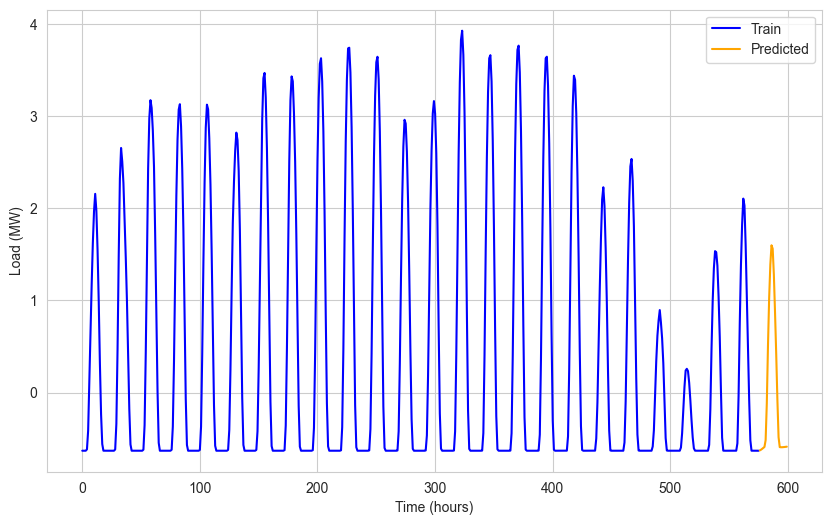

In [19]:
plot_predictions(train_ts, test_ts, forecasts)

In [20]:
df = pd.concat([test_ts.iloc[:, 1], forecasts], axis=1)
df.columns = ['Y_true', 'predicted'] 
df

,Y_true,predicted
2020-09-29 00:00:00,-0.630527,-0.627164
2020-09-29 01:00:00,-0.630527,-0.620076
2020-09-29 02:00:00,-0.630527,-0.610632
2020-09-29 03:00:00,-0.630527,-0.600209
2020-09-29 04:00:00,-0.630370,-0.589810
2020-09-29 05:00:00,-0.577614,-0.515511
2020-09-29 06:00:00,-0.205804,-0.116024
2020-09-29 07:00:00,0.363643,0.510003
2020-09-29 08:00:00,0.851673,1.025595
2020-09-29 09:00:00,1.247105,1.389291


In [21]:
np.sqrt(mean_squared_error(forecasts, test_ts.iloc[:, 1]))

0.08005574760037706

# 600 datapoints

# With exogenous

In [22]:
train, vali, test = split_scale_dataset(time_series.iloc[:, :-6], train_size, val_size)
train_ts = test[-600:-24]
train_ts_exog = test_exog[-600:-24]
test_ts = test[-24:]
test_ts_exog = test_exog[-24:]

30240 observations in the train dataset.
 8640 observations in the test dataset.
 4344 observations in the validation dataset.


In [23]:
import time 
start = time.time()

model = auto_arima(train_ts.iloc[:,1], exogenous=train_exog, stepwise=True, seasonal=True, m=24, maxiter=10)
forecasts, confidence = model.predict(test_ts.shape[0], exogenous = test_ts_exog, return_conf_int=True)

end = time.time()
print("Total time:", (end - start)/60, "min.")

Total time: 1.5683005889256796 min.


In [24]:
model.get_params('order')

{'maxiter': 10,
 'method': 'lbfgs',
 'order': (2, 0, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 0, 1, 24),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [25]:
model.order, model.seasonal_order

((2, 0, 1), (1, 0, 1, 24))

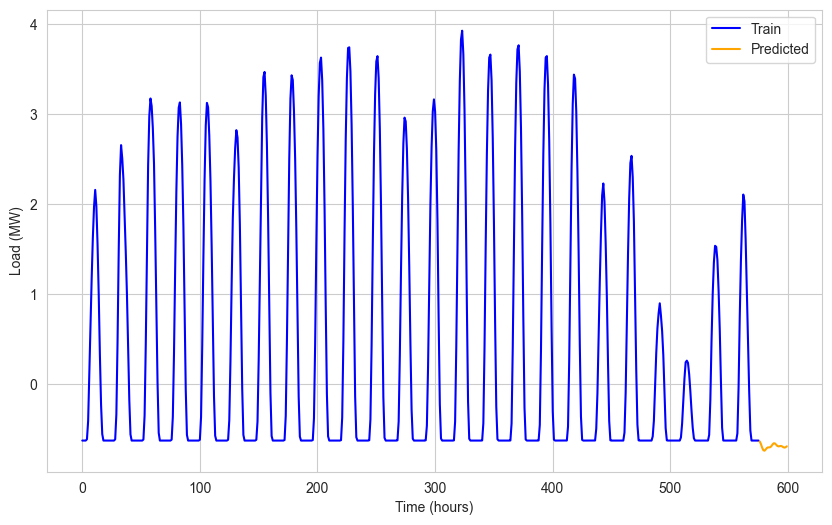

In [44]:
def plot_predictions(train, test, forecasts):
    sns.set_style("whitegrid")

    plt.figure(figsize=(10, 6))

    x = np.arange(train.shape[0] + test.shape[0])

    # Combine x and y data into a DataFrame
    data_train = {'Time': x[:train.shape[0]], 'Load': np.array(train.iloc[:, 1])}
    data_forecast = {'Time': x[train.shape[0]:], 'Load': forecasts}

    # Create line plots using Seaborn
    sns.lineplot(data=data_train, x='Time', y='Load', color='blue', label='Train')
    sns.lineplot(data=data_forecast, x='Time', y='Load', color='orange', label='Predicted')

    plt.xlabel("Time (hours)")
    plt.ylabel("Load (MW)")
    plt.legend()

    # Show the plot
    plt.show()

plot_predictions(train_ts, test_ts, forecasts)


In [27]:
df = pd.concat([test_ts.iloc[:, 1], forecasts], axis=1)
df.columns = ['Y_true', 'predicted'] 
df

,Y_true,predicted
2020-09-29 00:00:00,-0.630527,-0.627164
2020-09-29 01:00:00,-0.630527,-0.620076
2020-09-29 02:00:00,-0.630527,-0.610632
2020-09-29 03:00:00,-0.630527,-0.600209
2020-09-29 04:00:00,-0.630370,-0.589810
2020-09-29 05:00:00,-0.577614,-0.515511
2020-09-29 06:00:00,-0.205804,-0.116024
2020-09-29 07:00:00,0.363643,0.510003
2020-09-29 08:00:00,0.851673,1.025594
2020-09-29 09:00:00,1.247105,1.389290


In [28]:
np.sqrt(mean_squared_error(forecasts, test_ts.iloc[:, 1]))

0.08005546222889662

# Without exog

In [48]:
import time 
start = time.time()

model1 = auto_arima(train_ts.iloc[:,1], stepwise=True, seasonal=True, m=24, maxiter=10)
forecasts1, confidence = model1.predict(test_ts.shape[0], return_conf_int=True)

end = time.time()
print("Total time:", (end - start)/60, "min.")

Total time: 1.4939658164978027 min.


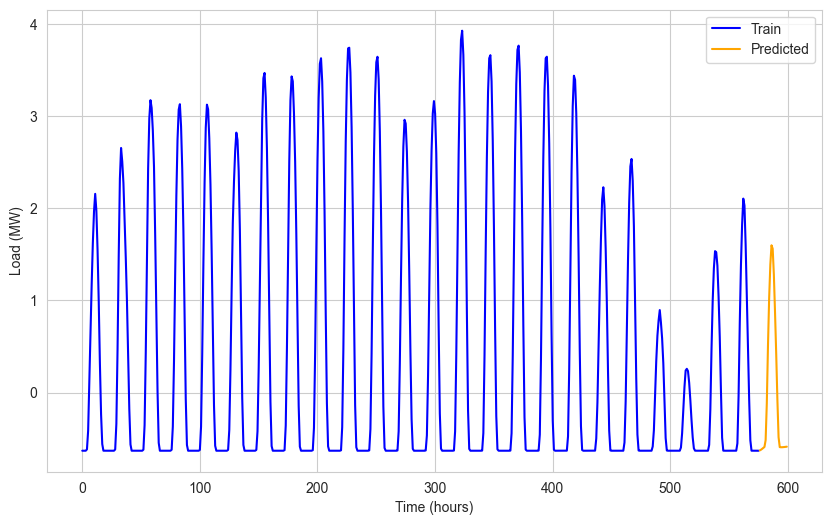

In [49]:
plot_predictions(train_ts, test_ts, forecasts1)

In [50]:
df = pd.concat([test_ts.iloc[:, 1], forecasts1], axis=1)
df.columns = ['Y_true', 'predicted'] 
df

,Y_true,predicted
2020-09-29 00:00:00,-0.630527,-0.627164
2020-09-29 01:00:00,-0.630527,-0.620076
2020-09-29 02:00:00,-0.630527,-0.610632
2020-09-29 03:00:00,-0.630527,-0.600209
2020-09-29 04:00:00,-0.630370,-0.589810
2020-09-29 05:00:00,-0.577614,-0.515511
2020-09-29 06:00:00,-0.205804,-0.116024
2020-09-29 07:00:00,0.363643,0.510003
2020-09-29 08:00:00,0.851673,1.025595
2020-09-29 09:00:00,1.247105,1.389291


In [51]:
np.sqrt(mean_squared_error(forecasts1, test_ts.iloc[:, 1]))

0.08005574760037706

In [226]:
forecasts1

2020-09-29 00:00:00   -0.627164
2020-09-29 01:00:00   -0.620076
2020-09-29 02:00:00   -0.610632
2020-09-29 03:00:00   -0.600209
2020-09-29 04:00:00   -0.589810
2020-09-29 05:00:00   -0.515511
2020-09-29 06:00:00   -0.116024
2020-09-29 07:00:00    0.510003
2020-09-29 08:00:00    1.025594
2020-09-29 09:00:00    1.389290
2020-09-29 10:00:00    1.597589
2020-09-29 11:00:00    1.560379
2020-09-29 12:00:00    1.280191
2020-09-29 13:00:00    0.866496
2020-09-29 14:00:00    0.416604
2020-09-29 15:00:00   -0.079330
2020-09-29 16:00:00   -0.483119
2020-09-29 17:00:00   -0.591557
2020-09-29 18:00:00   -0.592821
2020-09-29 19:00:00   -0.592537
2020-09-29 20:00:00   -0.591574
2020-09-29 21:00:00   -0.590146
2020-09-29 22:00:00   -0.588481
2020-09-29 23:00:00   -0.586791
Freq: H, dtype: float64

# Seasonal=False

In [227]:
start = time.time()

model2 = auto_arima(train_ts.iloc[:,1], exogenous = train_ts_exog, stepwise=True, seasonal=False, maxiter=10)
forecasts2, confidence = model2.predict(test_ts.shape[0], return_conf_int=True)

end = time.time()
print("Total time:", (end - start)/60, "min.")

Total time: 0.06373626391092936 min.


In [228]:
model2.order, model2.seasonal_order

((4, 0, 2), (0, 0, 0, 0))

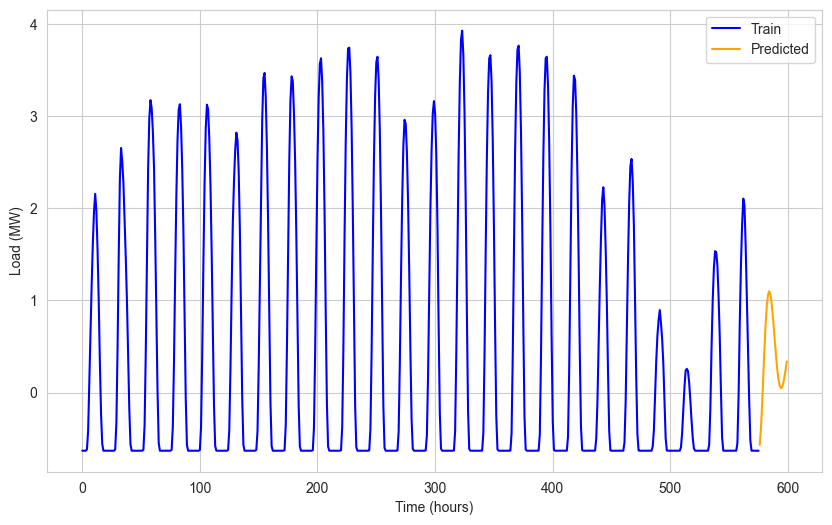

In [229]:
plot_predictions(train_ts, test_ts, forecasts2)

In [230]:
np.sqrt(mean_squared_error(forecasts2, test_ts.iloc[:, 1]))

0.702784700739592

# 90 days, 2184 (2160)

In [41]:
train_ts = test[-2184:-24]
train_ts_exog = test_exog[-2184:-24]
test_ts = test[-24:]
test_ts_exog = test_exog[-24:]

In [42]:
import time 
start = time.time()

model = auto_arima(train_ts.iloc[:,1], exogenous=train_exog, stepwise=True, seasonal=True, m=24, maxiter=10)
forecasts, confidence = model.predict(test_ts.shape[0], exogenous = test_ts_exog, return_conf_int=True)

end = time.time()
print("Total time:", (end - start)/60, "min.")

Total time: 4.175046896934509 min.


In [43]:
model.get_params('order')

{'maxiter': 10,
 'method': 'lbfgs',
 'order': (2, 0, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 0, 1, 24),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [44]:
model.order, model.seasonal_order

((2, 0, 1), (1, 0, 1, 24))

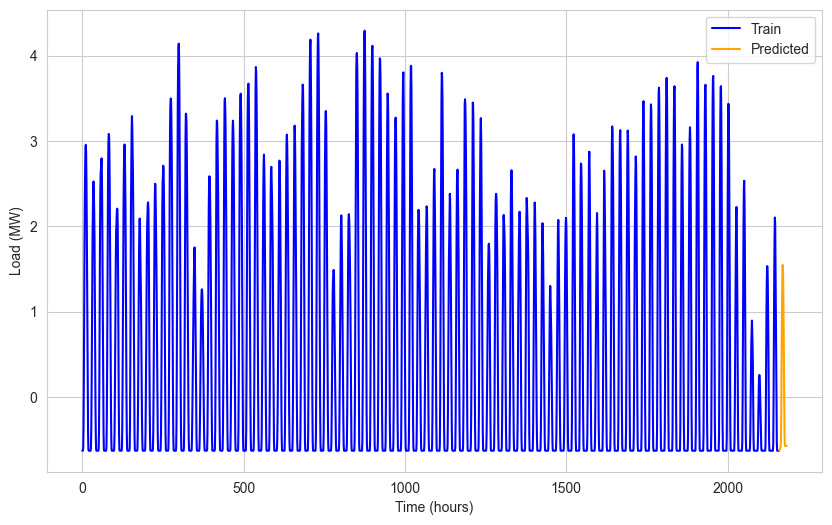

In [45]:
plot_predictions(train_ts, test_ts, forecasts)

In [46]:
df = pd.concat([test_ts.iloc[:, 1], forecasts], axis=1)
df.columns = ['Y_true', 'predicted'] 
df

,Y_true,predicted
2020-09-29 00:00:00,-0.630527,-0.626502
2020-09-29 01:00:00,-0.630527,-0.617818
2020-09-29 02:00:00,-0.630527,-0.605938
2020-09-29 03:00:00,-0.630527,-0.592370
2020-09-29 04:00:00,-0.630370,-0.578235
2020-09-29 05:00:00,-0.577614,-0.497597
2020-09-29 06:00:00,-0.205804,-0.119438
2020-09-29 07:00:00,0.363643,0.473411
2020-09-29 08:00:00,0.851673,0.980548
2020-09-29 09:00:00,1.247105,1.344062


In [47]:
np.sqrt(mean_squared_error(forecasts, test_ts.iloc[:, 1]))

0.07556180940940287

# Without exog

In [48]:
import time 
start = time.time()

model1 = auto_arima(train_ts.iloc[:,1], stepwise=True, seasonal=True, m=24, maxiter=10)
forecasts1, confidence = model1.predict(test_ts.shape[0], return_conf_int=True)

end = time.time()
print("Total time:", (end - start)/60, "min.")

Total time: 4.17824946641922 min.


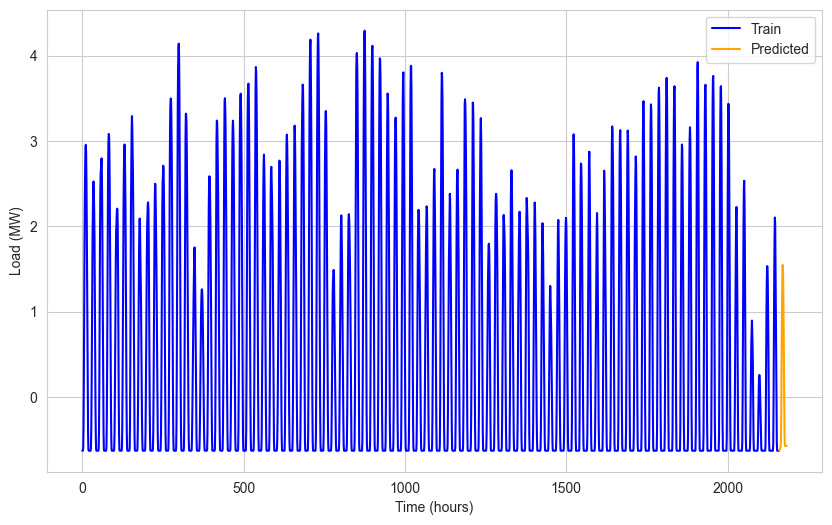

In [49]:
plot_predictions(train_ts, test_ts, forecasts1)

In [50]:
df = pd.concat([test_ts.iloc[:, 1], forecasts1], axis=1)
df.columns = ['Y_true', 'predicted'] 
df

,Y_true,predicted
2020-09-29 00:00:00,-0.630527,-0.626502
2020-09-29 01:00:00,-0.630527,-0.617818
2020-09-29 02:00:00,-0.630527,-0.605938
2020-09-29 03:00:00,-0.630527,-0.592370
2020-09-29 04:00:00,-0.630370,-0.578235
2020-09-29 05:00:00,-0.577614,-0.497597
2020-09-29 06:00:00,-0.205804,-0.119438
2020-09-29 07:00:00,0.363643,0.473411
2020-09-29 08:00:00,0.851673,0.980548
2020-09-29 09:00:00,1.247105,1.344062


In [241]:
# 0.07556180940940287
np.sqrt(mean_squared_error(forecasts1, test_ts.iloc[:, 1]))

0.07556182379935601

In [51]:
np.sqrt(mean_squared_error(forecasts1, test_ts.iloc[:, 1]))

0.07556180940940287

In [242]:
forecasts1

2020-09-29 00:00:00   -0.626502
2020-09-29 01:00:00   -0.617818
2020-09-29 02:00:00   -0.605938
2020-09-29 03:00:00   -0.592370
2020-09-29 04:00:00   -0.578235
2020-09-29 05:00:00   -0.497597
2020-09-29 06:00:00   -0.119438
2020-09-29 07:00:00    0.473411
2020-09-29 08:00:00    0.980548
2020-09-29 09:00:00    1.344062
2020-09-29 10:00:00    1.547358
2020-09-29 11:00:00    1.535154
2020-09-29 12:00:00    1.297904
2020-09-29 13:00:00    0.921468
2020-09-29 14:00:00    0.476133
2020-09-29 15:00:00   -0.031186
2020-09-29 16:00:00   -0.446722
2020-09-29 17:00:00   -0.568129
2020-09-29 18:00:00   -0.572814
2020-09-29 19:00:00   -0.574712
2020-09-29 20:00:00   -0.575449
2020-09-29 21:00:00   -0.575143
2020-09-29 22:00:00   -0.573981
2020-09-29 23:00:00   -0.572195
Freq: H, dtype: float64

# Seasonal=False

In [243]:
start = time.time()

model2 = auto_arima(train_ts.iloc[:,1], exogenous = train_ts_exog, stepwise=True, seasonal=False, maxiter=10)
forecasts2, confidence = model2.predict(test_ts.shape[0], return_conf_int=True)

end = time.time()
print("Total time:", (end - start)/60, "min.")

Total time: 0.26802250544230144 min.


In [244]:
model2.order, model2.seasonal_order

((4, 0, 2), (0, 0, 0, 0))

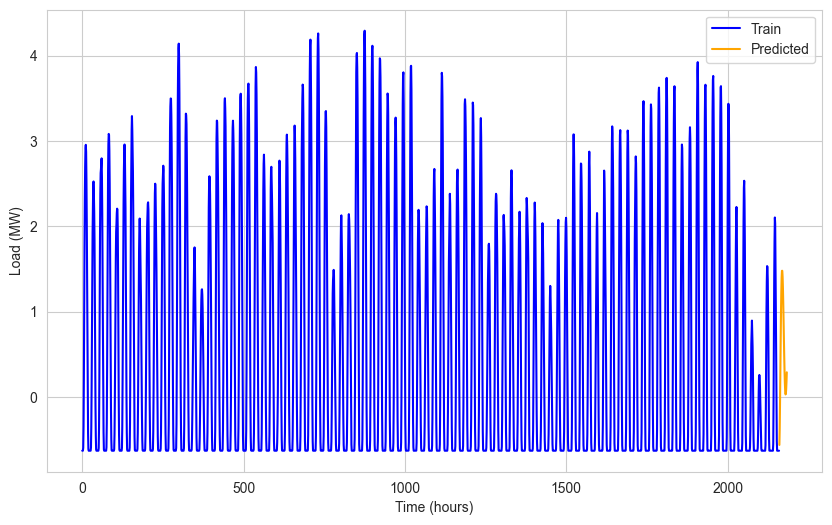

In [245]:
plot_predictions(train_ts, test_ts, forecasts2)

In [246]:
np.sqrt(mean_squared_error(forecasts2, test_ts.iloc[:, 1]))

0.7687107141675076

# With m=24

In [165]:
# The period for seasonal differencing, m refers to the number of periods in each season.
# For example, m is 4 for quarterly data, 12 for monthly data, or 1 for annual (non-seasonal) data. 
# Default is 1. Note that if m == 1 (i.e., is non-seasonal), seasonal will be set to False. For more 
#information on setting this parameter, see Setting m.


model = auto_arima(train_ts.iloc[:,0], stepwise=True, seasonal=True, m=24, maxiter=10)
# model = pm.auto_arima(combined_data, seasonal=False, stepwise=True, trace=False, suppress_warnings=True)
# Make a forecast for the current window
#forecast, conf_int = model.predict(n_periods=prediction_length, return_conf_int=True)
            

In [191]:
model.params

<bound method ARIMA.params of ARIMA(maxiter=3, order=(5, 0, 0), scoring_args={}, seasonal_order=(0, 0, 2, 24),
      suppress_warnings=True)>

In [ ]:
updated_model = model.update(test_ts.iloc[:,0])

# Step 3: Forecast
forecast = updated_model.predict(n_periods=24)


In [192]:
model2.params

<bound method ARIMA.params of ARIMA(maxiter=3, order=(2, 0, 4), scoring_args={}, suppress_warnings=True)>

In [166]:
forecasts, confidence = model.predict(test_ts.shape[0], return_conf_int=True)  # predict N steps into the future

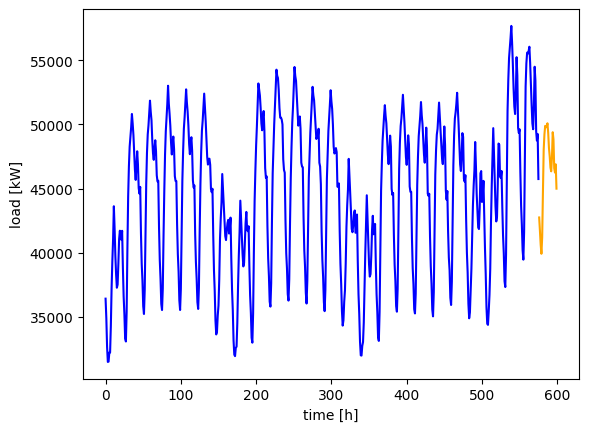

In [171]:
# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(train_ts.shape[0] + test_ts.shape[0])
plt.plot(x[:train_ts.shape[0]], np.array(train_ts.iloc[:, 0]), c='blue')
plt.plot(x[train_ts.shape[0]:], forecasts, c='orange')
plt.xlabel("time [h]")
plt.ylabel("load [kW]")
plt.show()

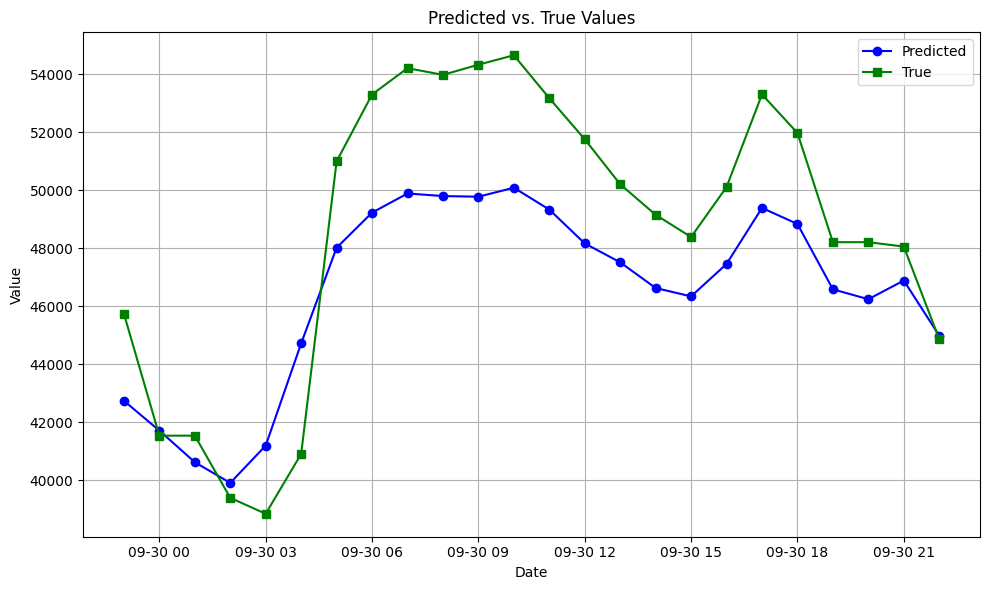

In [183]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(forecasts.index, forecasts, label='Predicted', color='blue', marker='o')  # Plot forecasted values
plt.plot(test_ts.index, test_ts.iloc[:, 0], label='True', color='green', marker='s')  # Plot true values
plt.xlabel('Date')  # Set x-axis label
plt.ylabel('Value')  # Set y-axis label
plt.title('Predicted vs. True Values')  # Set plot title
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.tight_layout()  # Adjust layout
plt.show()  # Display plot

In [176]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
np.sqrt(mean_squared_error(forecasts, test_ts.iloc[:, 0]))

3019.639899294806

In [177]:
mean_squared_error(forecasts, test_ts.iloc[:, 0])

9118225.121413147

In [182]:
df = pd.concat([test_ts.iloc[:, 0], forecasts], axis=1)
df.columns = ['Y_true', 'predicted'] 
df

,Y_true,predicted
2020-09-29 23:00:00,45740.0,42742.864115
2020-09-30 00:00:00,41540.0,41714.253527
2020-09-30 01:00:00,41540.0,40623.920446
2020-09-30 02:00:00,39396.0,39911.586563
2020-09-30 03:00:00,38846.0,41196.632844
2020-09-30 04:00:00,40910.0,44720.466419
2020-09-30 05:00:00,50996.0,48019.339309
2020-09-30 06:00:00,53301.0,49228.363408
2020-09-30 07:00:00,54210.0,49888.553852
2020-09-30 08:00:00,53978.0,49799.933336


# Seasonal=False

In [184]:
# 2.1 sec??????
model2 = auto_arima(train_ts.iloc[:,0], stepwise=True, seasonal=False, maxiter=3)

forecasts2, confidence2 = model2.predict(test_ts.shape[0], return_conf_int=True)  # predict N steps into the future


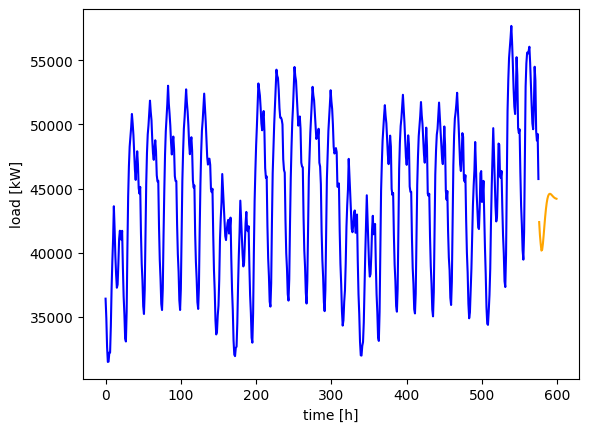

In [186]:
# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(train_ts.shape[0] + test_ts.shape[0])
plt.plot(x[:train_ts.shape[0]], np.array(train_ts.iloc[:, 0]), c='blue')
plt.plot(x[train_ts.shape[0]:], forecasts2, c='orange')
plt.xlabel("time [h]")
plt.ylabel("load [kW]")
plt.show()

In [189]:
np.sqrt(mean_squared_error(forecasts2, test_ts.iloc[:, 0]))

6780.192668328311

In [190]:
df = pd.concat([test_ts.iloc[:, 0], forecasts2], axis=1)
df.columns = ['Y_true', 'predicted'] 
df

,Y_true,predicted
2020-09-29 23:00:00,45740.0,42384.640177
2020-09-30 00:00:00,41540.0,41378.206071
2020-09-30 01:00:00,41540.0,40703.875271
2020-09-30 02:00:00,39396.0,40158.492307
2020-09-30 03:00:00,38846.0,40237.694983
2020-09-30 04:00:00,40910.0,40709.681417
2020-09-30 05:00:00,50996.0,41384.073128
2020-09-30 06:00:00,53301.0,42117.210937
2020-09-30 07:00:00,54210.0,42810.620243
2020-09-30 08:00:00,53978.0,43405.251377


In [42]:
# Study periods length
period_b = 0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250
period_e = 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250
# Split period into training, validation and test set
training_size = 750
test_size = 250

In [43]:
Results = pd.DataFrame(index = range(period_b[0], period_e[9] - training_size))
Results

""
0
1
2
3
4
...
2495
2496
2497
2498


In [44]:
for i in range(len(period_b)):
    print(i)

0
1
2
3
4
5
6
7
8
9


In [47]:
24*83

1992

In [48]:
24*365

8760

In [45]:
1923536/400

4808.84

In [ ]:
5*3

In [ ]:
Results = pd.DataFrame(index = range(period_b[0], period_e[9] - training_size))# 2500
for i in range(len(period_b)): # 0, 9
    for j in range(len(Target_feature.columns)): # 35
        # 750 from 0
        training = Target_feature.iloc[period_b[i] : period_b[i] + training_size, j].to_list()
        # 250 from 0
        test = Target_feature.iloc[period_e[i] - test_size : period_e[i], j].reset_index(drop = True)
        exogenous = Exogenous[period_b[0] : period_b[0] + training_size]

        with np.errstate(divide='ignore'):
            arima_model = auto_arima(training, exogenous, start_p = 0, start_q = 0, seasonal = False)
        predictions = []
        for k in range(test_size):
            model = ARIMA(training, exogenous, order = arima_model.get_params().get("order"))
            model_fit = model.fit()
            predictions.append(model_fit.forecast(exog = Exogenous[k + training_size])[0])
            training.append(test[k])
            exogenous.append(Exogenous[k + training_size])
        Results.iloc[period_b[i] : period_b[i] + test_size, j] = predictions